In [1]:
import torch
import utils
import numpy as np
import scanpy as sc
from torch import nn
from trainer import concrete_trainer
from network import ConcreteAutoencoder
%matplotlib inline

/home/qinxianhan/.conda/envs/singleCell/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
h5ad_path = "../../data/filtered_hg19.h5ad"
device = utils.get_device()
#device = torch.device("cpu")
device

device(type='cuda', index=1)

In [3]:
adata = sc.read_h5ad(h5ad_path )
adata.shape

(2700, 5001)

In [ ]:

tf_adata = utils.get_TF("../../data/tf/TF_uniq.txt", adata, target_index)
tf_adata.shape
tf_adata[:,-1]

In [5]:
def get_net(input_dim, k, hidden_dim,out_dim ,device):
    return ConcreteAutoencoder(input_dim, k,hidden_dim,out_dim,device = device)
def load_adata(adata, batch_size):
    return utils.data_loader(adata, batch_size)

In [9]:
num_epoch, learning_rate, weight_dacay, batch_size = 256, 0.001, 0, 256
input_dim = adata.shape[1]
init_temp = 10
end_temp = 0.01
loss = utils.HurdleLoss()
net = get_net(input_dim=input_dim, k=300, hidden_dim=512, out_dim = input_dim*2, device=device)
dataloader = load_adata(adata=adata, batch_size=batch_size)

In [10]:
concrete_trainer(net=net, loss=loss, dataloader=dataloader,
      num_epoch=num_epoch, learning_rate=learning_rate,
      weight_decay=weight_dacay ,device=device, init_temp=init_temp, 
      end_temp= end_temp)

Epoch: 1 ; Loss: 23361.67969; Temperature: 9.734; Time: 0.37 s
Epoch: 2 ; Loss: 9038.52148; Temperature: 9.475; Time: 0.82 s
Epoch: 3 ; Loss: 7704.70850; Temperature: 9.222; Time: 1.30 s
Epoch: 4 ; Loss: 7319.62598; Temperature: 8.977; Time: 1.75 s
Epoch: 5 ; Loss: 7144.63184; Temperature: 8.738; Time: 2.24 s
Epoch: 6 ; Loss: 7070.16504; Temperature: 8.505; Time: 2.71 s
Epoch: 7 ; Loss: 7028.96875; Temperature: 8.279; Time: 3.20 s
Epoch: 8 ; Loss: 6978.73438; Temperature: 8.058; Time: 3.84 s
Epoch: 9 ; Loss: 6921.88184; Temperature: 7.844; Time: 4.30 s
Epoch: 10 ; Loss: 6855.89209; Temperature: 7.635; Time: 4.74 s
Epoch: 11 ; Loss: 6778.20703; Temperature: 7.432; Time: 5.24 s
Epoch: 12 ; Loss: 6683.79932; Temperature: 7.234; Time: 5.77 s
Epoch: 13 ; Loss: 6562.26562; Temperature: 7.041; Time: 6.21 s
Epoch: 14 ; Loss: 6398.62646; Temperature: 6.854; Time: 6.70 s
Epoch: 15 ; Loss: 6213.34619; Temperature: 6.671; Time: 7.11 s
Epoch: 16 ; Loss: 6016.09033; Temperature: 6.494; Time: 7.55 s


In [11]:
x_val = torch.Tensor(adata.X.A).to(device) # type: ignore
_, z, m = net(x_val, temperature = end_temp)
z.shape

torch.Size([2700, 300])

In [12]:
z = z.to('cpu').detach().numpy()
m = m.to('cpu').detach().numpy()

In [13]:
import numpy as np
import pandas as pd
import anndata as ad
import scanpy as sc

In [14]:
res_adata = ad.AnnData(z)
res_adata.shape

(2700, 300)

In [15]:
sc.tl.pca(res_adata, svd_solver='arpack')


/home/qinxianhan/.conda/envs/singleCell/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


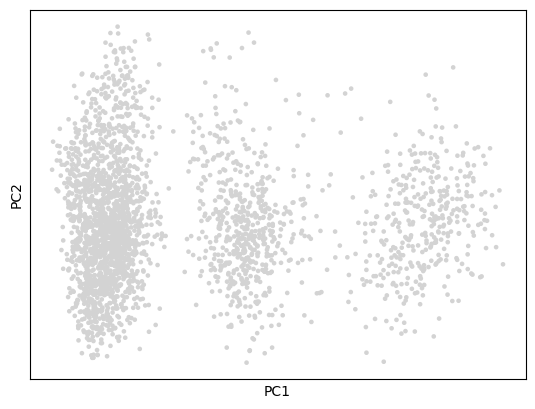

In [16]:
sc.pl.pca(res_adata)

In [30]:
sc.pp.neighbors(res_adata, n_neighbors=20, n_pcs=40)
sc.tl.umap(res_adata)
sc.tl.leiden(res_adata)

/home/qinxianhan/.conda/envs/singleCell/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


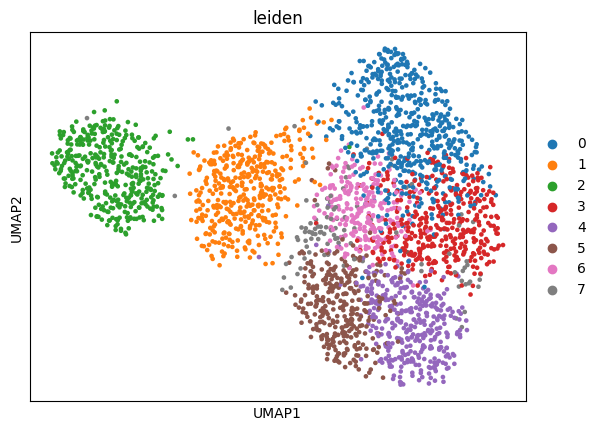

In [32]:

sc.pl.umap(res_adata, color='leiden')

In [33]:
res_adata

AnnData object with n_obs × n_vars = 2700 × 300
    obs: 'leiden'
    uns: 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'tsne'
    obsm: 'X_pca', 'X_umap', 'X_tsne'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [ ]:
selected_tf = np.zeros([10,10])
for i in range(10):
    net = get_net(input_dim=input_dim, k=10, hidden_dim=128, device=device)
    dataloader = load_adata(adata=tf_adata, batch_size=batch_size)
    concrete_trainer(net=net, loss=loss, dataloader=dataloader,
      num_epoch=num_epoch, learning_rate=learning_rate,
      weight_decay=weight_dacay ,device=device, init_temp=init_temp, 
      end_temp= end_temp)
    x_val = torch.Tensor(tf_adata.X.A[:,0:-1]).to(device)
    _, z, m = net(x_val, temperature = end_temp)
    m = m.to('cpu').detach().numpy()
    selected_tf[i] = np.argmax(m,axis=0)

In [ ]:
selected_tf

In [ ]:
idx, freq = np.unique(selected_tf, return_counts=True)
idx, freq

In [ ]:
idx = idx[np.argsort(freq)][::-1].astype(int)
tf_adata.var_names[idx]

In [ ]:
max_idx = []
for i in range(m.shape[1]):
    max_idx.append(np.argmax(m[:,i]))
max_idx

In [ ]:
for i in range(m.shape[1]):
    print(max(m[:,i]))

In [ ]:
def find_same(index):
    count = 0
    for i in range(1,len(index)):
        for j in range(i):
            if index[j] == index[i]:
                count +=1
    print(count)  

In [ ]:
find_same(max_idx)

In [ ]:
res_genes = adata.var_names[max_idx]

In [ ]:
res_adata.var_names = res_genes # type: ignore

In [ ]:
sc.tl.rank_genes_groups(res_adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(res_adata, n_genes=25, sharey=False)

In [ ]:
adata = utils.anndata_load(file_path=file_path)
adata = utils.anndata_preprocess(adata=adata,n_top_genes=1000)

In [ ]:
var_genes = adata.var_names

In [ ]:
res_adata.var_names_make_unique()

In [ ]:
s = set(res_adata.var_names)

In [ ]:
temp1 = [x for x in var_genes if x not in s]

In [ ]:
len(temp1)

In [ ]:
temp2 = [x for x in s if x not in var_genes]

In [ ]:
len(temp2)

In [ ]:
temp1

In [ ]:
temp2